In [1]:
import torch
from torch import nn
import numpy as np
from PolConfML.model import Network, Dataset
from PolConfML.utils import load_descs, save_descs
import time
import matplotlib.pyplot as plt

dtype = torch.float32

In [2]:
path = 'data_SrTiO3/split/'

# train
descs_train, indices_train = load_descs(path+'train/',['S0','S1','S2'])
Y_train = np.array(np.load(path+'train/Y.npy'))
defects_train = np.load(path+'train/defect.npy')
n = [descs_train[site].shape[0] for site in descs_train]

#val
descs_val,indices_val = load_descs(path+'val/',['S0','S1','S2'])
Y_val = np.load(path+'val/Y.npy')
defects_val = np.load(path+'val/defect.npy')

# test
descs_test,  indices_test = load_descs(path+'test/',['S0','S1','S2'])
Y_test = np.load(path+'test/Y.npy')
defects_test = np.load(path+'test/defect.npy')

data_train = Dataset(descs_train, indices_train, Y_train, defects_train)
data_train.kernel(0.3)

data_val = Dataset(descs_val, indices_val, Y_val, defects_val)
data_val.descs = data_train.kernel_test(data_val)

data_test = Dataset(descs_test, indices_test, Y_test, defects_test)
data_test.descs = data_train.kernel_test(data_test)

In [3]:
net = Network(n)
criterion = nn.MSELoss(reduction='sum')
batch_size = 64

learn_curve_train = []
learn_curve_val = []
epochs = []
lowest_loss = 1000

optimizer = torch.optim.Adam(net.parameters(),lr=0.0002,eps=1e-8, weight_decay=0.1)
start = time.time()
losses = []
for epoch in range(30001):
    optimizer.zero_grad()
    loss = 0
    for i in np.random.randint(0,len(data_train),size=batch_size):
        x,y,ov = data_train[i]
        loss+=criterion(net(x),y)*8/ov

    loss.backward()

    with torch.no_grad():
        for i,param in enumerate(net.parameters()):
            if torch.isnan(torch.norm(param.grad)):
                param.grad[torch.isnan(param.grad).nonzero()] = 0
                
    optimizer.step()
    losses.append(loss.item()/batch_size)
    if epoch%100 == 0:
        end = time.time()
        val_loss = []
        with torch.no_grad():
            for x,y,ov in data_val:
                val_loss.append((criterion(net(x),y)*8/ov).item())
        learn_curve_train.append(np.mean(losses))
        learn_curve_val.append(np.mean(val_loss))
        epochs.append(epoch)
        print('Epoch : %d \tLoss : %.6f \tVal_Loss : %.6f\tTime : %.3f seconds ' % (epoch, 
                                                                                    learn_curve_train[-1],
                                                                                    learn_curve_val[-1], 
                                                                                    end - start))
        if learn_curve_val[-1] < lowest_loss:
            torch.save(net, 'data_SrTiO3/model.pt')
            lowest_loss = learn_curve_val[-1].copy()
            print('saved model')
        start = time.time()
        losses = []

Epoch : 0 	Loss : 6.431288 	Val_Loss : 4.311964	Time : 0.020 seconds 
saved model
Epoch : 100 	Loss : 0.239994 	Val_Loss : 0.047205	Time : 1.346 seconds 
saved model
Epoch : 200 	Loss : 0.029317 	Val_Loss : 0.030533	Time : 1.364 seconds 
saved model
Epoch : 300 	Loss : 0.021269 	Val_Loss : 0.023785	Time : 1.323 seconds 
saved model
Epoch : 400 	Loss : 0.019543 	Val_Loss : 0.022209	Time : 1.364 seconds 
saved model
Epoch : 500 	Loss : 0.018246 	Val_Loss : 0.020090	Time : 1.406 seconds 
saved model
Epoch : 600 	Loss : 0.016556 	Val_Loss : 0.019135	Time : 1.325 seconds 
saved model
Epoch : 700 	Loss : 0.014935 	Val_Loss : 0.016810	Time : 1.324 seconds 
saved model
Epoch : 800 	Loss : 0.014708 	Val_Loss : 0.017101	Time : 1.335 seconds 
Epoch : 900 	Loss : 0.012482 	Val_Loss : 0.014972	Time : 1.325 seconds 
saved model
Epoch : 1000 	Loss : 0.012783 	Val_Loss : 0.015793	Time : 1.321 seconds 
Epoch : 1100 	Loss : 0.011884 	Val_Loss : 0.013015	Time : 1.310 seconds 
saved model
Epoch : 1200 	Lo

In [4]:
net = torch.load('data_SrTiO3/model.pt')

# results

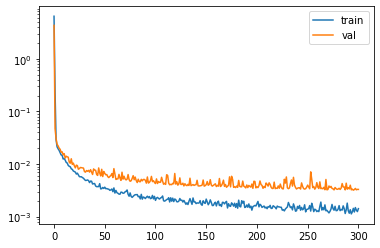

In [5]:
import matplotlib.pyplot as plt
plt.semilogy(learn_curve_train, label='train')
plt.semilogy(learn_curve_val, label='val')
plt.legend()

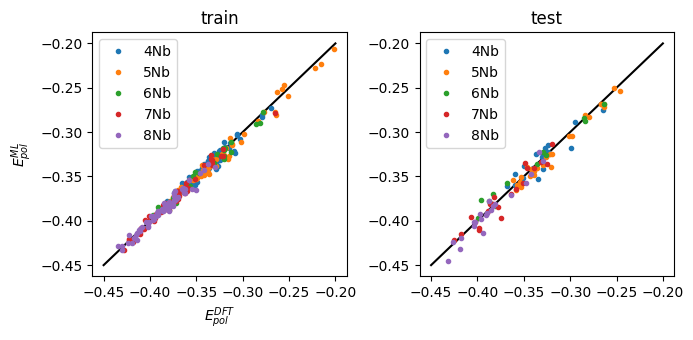

In [8]:
plt.figure(figsize=(7,3.5), dpi=100)
k=1
res = {title:{label:None for label in ['true', 'pred', 'nbs']} for title in ['train', 'test']}
for data,title in zip([data_train, data_test],['train','test']):

    true = []
    pred = []
    nbs = []
    if title=='test':
        for x,y,ov in data_val:
            true.append(y/(1*ov))
            pred.append(net(x).item()/(1*ov))
            nbs.append(ov.item())
        for x,y,ov in data_test:
            true.append(y/(1*ov))
            pred.append(net(x).item()/(1*ov))
            nbs.append(ov.item())
    else:
        for x,y,ov in data:
            true.append(y/(1*ov))
            pred.append(net(x).item()/(1*ov))
            nbs.append(ov.item())
    
    
    true = np.array(true)
    pred = np.array(pred)
    nbs = np.array(nbs)
    res[title]['true'] = true
    res[title]['pred'] = pred
    res[title]['nbs'] = nbs
    plt.subplot(1,2,k)
    plt.title(title)
    for i in range(4,9):
        plt.plot(true[nbs==i],pred[nbs==i],'.',label=str(i)+'Nb')
    plt.plot([-0.45,-0.2],[-0.45,-0.2],'k',zorder=0)
    plt.legend()
    if k==1:
        plt.xlabel('$E_{pol}^{DFT}$')
        plt.ylabel('$E_{pol}^{ML}$')
    k+=1
plt.tight_layout()

In [9]:
print('MSE training:\t', np.mean((res['train']['true']-res['train']['pred'])**2))
print('MSE test:\t', np.mean((res['test']['true']-res['test']['pred'])**2))

MSE training:	 2.4363122e-05
MSE test:	 6.344638e-05


# split by defect

In [10]:
res ={i:{
    label:{
        'true':None, 'pred':None, 'nbs':None
    } for label in ['train', 'val', 'test']} 
      for i in range(4,9)}

for j in range(4,9):
    print(j)
    path = 'data_SrTiO3/split_defect/'+str(j)+'Nb/'

    # train
    descs_train, indices_train = load_descs(path+'train/',['S0','S1','S2'])
    Y_train = np.array(np.load(path+'train/Y.npy'))
    defects_train = np.load(path+'train/defect.npy')
    n = [descs_train[site].shape[0] for site in descs_train]

    #val
    descs_val,indices_val = load_descs(path+'val/',['S0','S1','S2'])
    Y_val = np.load(path+'val/Y.npy')
    defects_val = np.load(path+'val/defect.npy')

    # test
    descs_test,  indices_test = load_descs(path+'test/',['S0','S1','S2'])
    Y_test = np.load(path+'test/Y.npy')
    defects_test = np.load(path+'test/defect.npy')

    # data
    data_train = Dataset(descs_train, indices_train, Y_train, defects_train)
    data_train.kernel(0.3)

    data_val = Dataset(descs_val, indices_val, Y_val, defects_val)
    data_val.descs = data_train.kernel_test(data_val)

    data_test = Dataset(descs_test, indices_test, Y_test, defects_test)
    data_test.descs = data_train.kernel_test(data_test)
    
    net = Network(n)
    criterion = nn.MSELoss(reduction='sum')
    batch_size = 64

    learn_curve_train = []
    learn_curve_val = []
    epochs = []

    optimizer = torch.optim.Adam(net.parameters(),lr=0.0005,eps=1e-8, weight_decay=0.1)
    start = time.time()
    losses = []
    for epoch in range(5001):
        optimizer.zero_grad()
        loss = 0
        for i in np.random.randint(0,len(data_train),size=batch_size):
            x,y,ov = data_train[i]
            loss+=criterion(net(x),y)*8/ov

        loss.backward()

        with torch.no_grad():
            for i,param in enumerate(net.parameters()):
                if torch.isnan(torch.norm(param.grad)):
                    param.grad[torch.isnan(param.grad).nonzero()] = 0

        optimizer.step()
        losses.append(loss.item()/batch_size)
        if epoch%100 == 0:
            end = time.time()
            val_loss = []
            with torch.no_grad():
                for x,y,ov in data_val:
                    val_loss.append((criterion(net(x),y)*8/ov).item())
            learn_curve_train.append(np.mean(losses))
            learn_curve_val.append(np.mean(val_loss))
            epochs.append(epoch)
            print('Epoch : %d \tLoss : %.6f \tVal_Loss : %.6f\tTime : %.3f seconds ' % (epoch, 
                                                                                        learn_curve_train[-1],
                                                                                        learn_curve_val[-1], 
                                                                                        end - start))
            start = time.time()
            losses = []
            
    for data,title in zip([data_train, data_val, data_test],['train','val','test']):
        true = []
        pred = []
        nbs = []

        for x,y,ov in data:
            true.append(y/(1*ov))
            pred.append(net(x).item()/(1*ov))
            nbs.append(ov.item())
        true = np.array(true)
        pred = np.array(pred)
        nbs = np.array(nbs)
        res[j][title]['true'] = true
        res[j][title]['pred'] = pred
        res[j][title]['nbs'] = nbs
            

4
Epoch : 0 	Loss : 6.719126 	Val_Loss : 3.062074	Time : 0.016 seconds 
Epoch : 100 	Loss : 0.212985 	Val_Loss : 0.028908	Time : 1.349 seconds 
Epoch : 200 	Loss : 0.025822 	Val_Loss : 0.021800	Time : 1.324 seconds 
Epoch : 300 	Loss : 0.020978 	Val_Loss : 0.019973	Time : 1.290 seconds 
Epoch : 400 	Loss : 0.018374 	Val_Loss : 0.017468	Time : 1.292 seconds 
Epoch : 500 	Loss : 0.015813 	Val_Loss : 0.016039	Time : 1.291 seconds 
Epoch : 600 	Loss : 0.013819 	Val_Loss : 0.017458	Time : 1.301 seconds 
Epoch : 700 	Loss : 0.012205 	Val_Loss : 0.009661	Time : 1.289 seconds 
Epoch : 800 	Loss : 0.010947 	Val_Loss : 0.017412	Time : 1.300 seconds 
Epoch : 900 	Loss : 0.009578 	Val_Loss : 0.008504	Time : 1.306 seconds 
Epoch : 1000 	Loss : 0.008603 	Val_Loss : 0.011707	Time : 1.313 seconds 
Epoch : 1100 	Loss : 0.007705 	Val_Loss : 0.007373	Time : 1.312 seconds 
Epoch : 1200 	Loss : 0.007286 	Val_Loss : 0.006283	Time : 1.308 seconds 
Epoch : 1300 	Loss : 0.007226 	Val_Loss : 0.006064	Time : 1.3

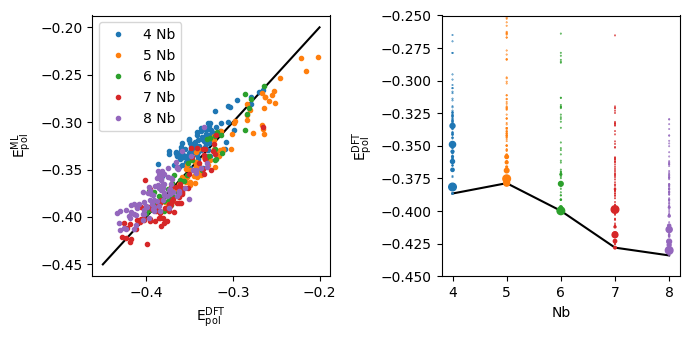

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3.5), dpi=100)
show = [4,5,6,7,8]

plt.subplot(1,2,1)
for i in show:
    plt.plot(res[i]['test']['true'], res[i]['test']['pred'], '.', label=str(i)+' Nb')
plt.plot([-0.45,-0.2],[-0.45,-0.2],'k', zorder=0)
plt.xlabel('E$_\mathrm{pol}^\mathrm{DFT}$')
plt.ylabel('E$_\mathrm{pol}^\mathrm{ML}$')
plt.legend()

plt.subplot(1,2,2)
plt.plot([i for i in show],
         [np.min(res[i]['test']['true']) for i in show],
         'k', zorder=0)

for i in show:
    values = res[i]['test']['true'][np.argsort(res[i]['test']['pred'])]
    x = np.linspace(0,1,len(values))
    s = (np.exp(-40*x)+0.005)*30
    plt.scatter(res[i]['test']['nbs'], values, s=s)
plt.ylim([-0.45,-0.25])
plt.xlabel('Nb')
plt.ylabel('E$_\mathrm{pol}^\mathrm{DFT}$')

plt.tight_layout()